In [2]:
pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 53.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


Chargement et préparation des données...
Chargement de l'enregistrement 100...
  Enregistrement 100: 2272 battements extraits
Chargement de l'enregistrement 101...
  Enregistrement 101: 1873 battements extraits
Chargement de l'enregistrement 102...
  Enregistrement 102: 2191 battements extraits
Chargement de l'enregistrement 103...
  Enregistrement 103: 2090 battements extraits
Chargement de l'enregistrement 104...
  Enregistrement 104: 2309 battements extraits
Chargement de l'enregistrement 105...
  Enregistrement 105: 2690 battements extraits
Chargement de l'enregistrement 106...
  Enregistrement 106: 2098 battements extraits
Chargement de l'enregistrement 107...
  Enregistrement 107: 2139 battements extraits
Chargement de l'enregistrement 108...
  Enregistrement 108: 1823 battements extraits
Chargement de l'enregistrement 109...
  Enregistrement 109: 2533 battements extraits
Chargement de l'enregistrement 111...
  Enregistrement 111: 2132 battements extraits
Chargement de l'enregist

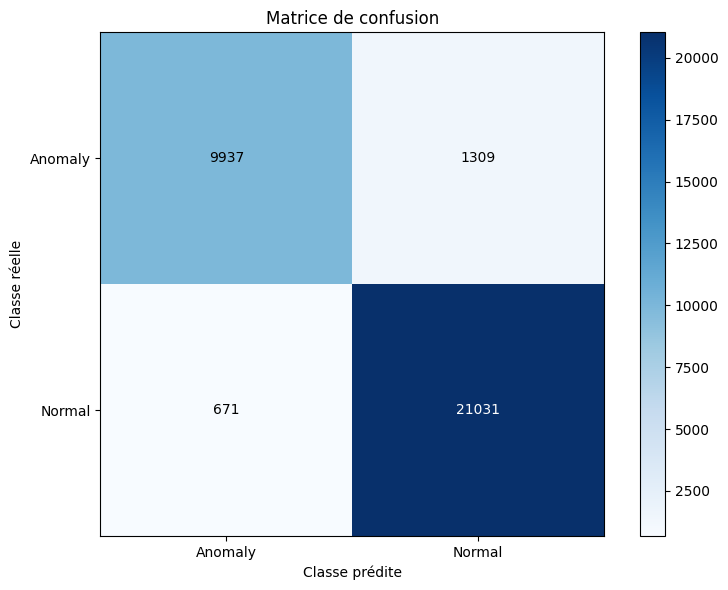


Déploiement du modèle...
Modèle sauvegardé dans 'ecg_model.pkl'

Test du modèle déployé...


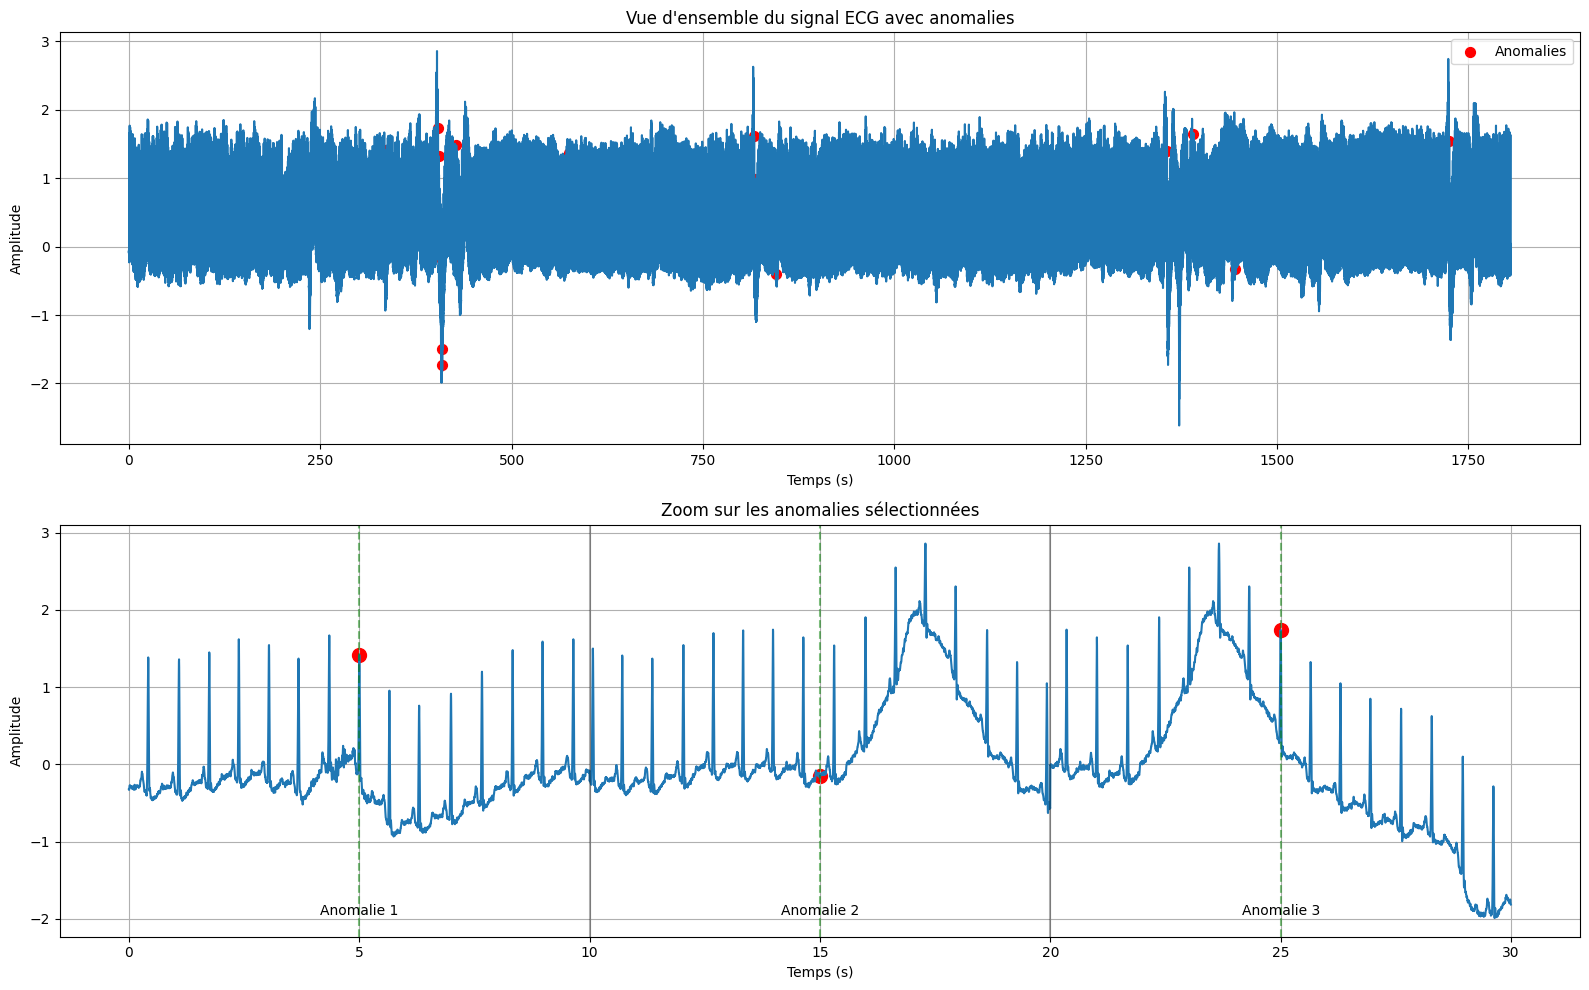

Nombre total de battements: 2763
Nombre d'anomalies détectées: 23 (0.8%)

Probabilités des anomalies détectées:
  Anomalie 1: 0.3924
  Anomalie 2: 0.0758
  Anomalie 3: 0.3410
  Anomalie 4: 0.4970
  Anomalie 5: 0.3436
  Anomalie 6: 0.1937
  Anomalie 7: 0.1218
  Anomalie 8: 0.4198
  Anomalie 9: 0.4345
  Anomalie 10: 0.2364
  Anomalie 11: 0.4784
  Anomalie 12: 0.0000
  Anomalie 13: 0.0133
  Anomalie 14: 0.3863
  Anomalie 15: 0.1999
  Anomalie 16: 0.3833
  Anomalie 17: 0.2401
  Anomalie 18: 0.4679
  Anomalie 19: 0.3985
  Anomalie 20: 0.1401
  Anomalie 21: 0.0100
  Anomalie 22: 0.0034
  Anomalie 23: 0.1812

Phase 2 terminée!


In [3]:
# Phase 2 : Sélectionner un modèle prédictif - Déploiement du modèle
# BUT RT3 - Parcours Cybersécurité

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
from scipy import signal

# 1. Chargement et préparation des données
# ---------------------------------------------------
print("Chargement et préparation des données...")

# Fonction de prétraitement simple
def preprocess_signal(signal_data):
    # Simple normalisation
    normalized = (signal_data - np.mean(signal_data)) / np.std(signal_data)
    return normalized

# Fonction pour segmenter les battements
def segment_beats(signal_data, annotations, window_size=150):
    beats = []
    labels = []

    for i, sample in enumerate(annotations.sample):
        # S'assurer que la fenêtre est dans les limites du signal
        if sample - window_size//2 >= 0 and sample + window_size//2 < len(signal_data):
            # Extraire le battement
            beat = signal_data[sample - window_size//2:sample + window_size//2]
            beats.append(beat)
            labels.append(annotations.symbol[i])

    return np.array(beats), np.array(labels)

# Charger plusieurs enregistrements ECG
record_ids = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233']
all_beats = []
all_labels = []

for record_id in record_ids:
    try:
        print(f"Chargement de l'enregistrement {record_id}...")
        record = wfdb.rdrecord(record_id, pn_dir='mitdb')
        annotation = wfdb.rdann(record_id, 'atr', pn_dir='mitdb')

        # Prétraitement et segmentation
        preprocessed_signal = preprocess_signal(record.p_signal[:, 0])
        beats, labels = segment_beats(preprocessed_signal, annotation)

        print(f"  Enregistrement {record_id}: {len(beats)} battements extraits")
        all_beats.extend(beats)
        all_labels.extend(labels)
    except Exception as e:
        print(f"  Erreur lors du chargement de l'enregistrement {record_id}: {e}")

# Convertir en tableaux numpy
all_beats = np.array(all_beats)
all_labels = np.array(all_labels)

print(f"\nNombre total de battements extraits: {len(all_beats)}")

# Simplifier les classes (regrouper en normal vs anormal)
y = np.array(['Normal' if lbl == 'N' else 'Anomaly' for lbl in all_labels])

# Extraire les caractéristiques des battements (version améliorée)
def extract_features(beats):
    features = []
    for beat in beats:
        # Caractéristiques de base
        mean = np.mean(beat)
        std = np.std(beat)
        min_val = np.min(beat)
        max_val = np.max(beat)
        amplitude = max_val - min_val

        # Caractéristiques supplémentaires
        median = np.median(beat)
        rms = np.sqrt(np.mean(np.square(beat)))  # Root Mean Square
        skewness = np.mean((beat - mean)**3) / (std**3) if std > 0 else 0
        kurtosis = np.mean((beat - mean)**4) / (std**4) if std > 0 else 0

        # Caractéristiques de forme d'onde
        zero_crossings = np.sum(np.diff(np.signbit(beat).astype(int)) != 0)

        features.append([mean, std, min_val, max_val, amplitude,
                        median, rms, skewness, kurtosis, zero_crossings])

    return np.array(features)

# Extraire les caractéristiques
X = extract_features(all_beats)
print(f"Dimensions des caractéristiques: {X.shape}")

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalisation des caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Modèle Random Forest avec améliorations
# ---------------------------------------------------
print("\nEntraînement du modèle Random Forest...")

# Création et entraînement du modèle (avec paramètres améliorés)
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',  # Pour gérer le déséquilibre des classes
    max_features='sqrt',      # Améliore généralement les performances
    min_samples_leaf=2        # Aide à éviter le surapprentissage
)

# Validation croisée pour évaluation plus robuste
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1_macro')
print(f"Scores de validation croisée (F1 macro): {cv_scores}")
print(f"Score moyen: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Entraînement du modèle final
model.fit(X_train_scaled, y_train)

# Évaluation du modèle
y_pred = model.predict(X_test_scaled)

# Affichage des métriques
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle: {accuracy:.4f}")
print("\nRapport de classification:")
print(classification_report(y_test, y_pred, zero_division=0))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')

# Ajout des valeurs dans les cellules
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# 3. Déploiement du modèle
# ---------------------------------------------------
print("\nDéploiement du modèle...")

# Sauvegarde du modèle et du scaler
model_data = {
    'model': model,
    'scaler': scaler,
    'window_size': 150,
    'feature_extractor': extract_features  # Ajouté pour avoir accès à la fonction
}

with open('ecg_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Modèle sauvegardé dans 'ecg_model.pkl'")

# 4. Classe pour la détection d'anomalies
# ---------------------------------------------------
class ECGAnomalyDetector:
    def __init__(self, model_data):
        self.model = model_data['model']
        self.scaler = model_data['scaler']
        self.window_size = model_data['window_size']
        self.feature_extractor = model_data.get('feature_extractor', extract_features)

    def preprocess_signal(self, signal_data):
        return (signal_data - np.mean(signal_data)) / np.std(signal_data)

    def detect_anomalies(self, signal_data, annotation=None):
        # Prétraitement du signal
        preprocessed = self.preprocess_signal(signal_data)

        # Si aucune annotation n'est fournie, utiliser la détection de pics R simple
        if annotation is None:
            # Méthode simple pour détecter les pics R (à améliorer en pratique)
            from scipy.signal import find_peaks
            peaks, _ = find_peaks(preprocessed, height=0.5, distance=100)

            # Créer un objet annotation compatible
            class SimpleAnnotation:
                def __init__(self, sample):
                    self.sample = sample

            annotation = SimpleAnnotation(peaks)

        # Segmenter les battements
        beats = []
        beat_indices = []  # Pour stocker les indices des battements

        for i, sample in enumerate(annotation.sample):
            if sample - self.window_size//2 >= 0 and sample + self.window_size//2 < len(preprocessed):
                beat = preprocessed[sample - self.window_size//2:sample + self.window_size//2]
                beats.append(beat)
                beat_indices.append(i)

        if len(beats) == 0:
            return {"error": "Aucun battement détecté"}

        # Extraire les caractéristiques
        features = self.feature_extractor(np.array(beats))

        # Normaliser les caractéristiques
        features_scaled = self.scaler.transform(features)

        # Prédiction
        predictions = self.model.predict(features_scaled)
        probas = self.model.predict_proba(features_scaled)

        # Résultats
        results = {
            "n_beats": len(beats),
            "predictions": predictions,
            "probabilities": probas,
            "beat_indices": beat_indices,
            "anomaly_indices": [beat_indices[i] for i, pred in enumerate(predictions) if pred == "Anomaly"]
        }

        return results

    def visualize_results(self, signal_data, results, annotation, fs=360):
        if "error" in results:
            print(f"Erreur: {results['error']}")
            return

        # Obtenir les indices des anomalies
        anomaly_samples = [annotation.sample[i] for i in results["anomaly_indices"]]

        if not anomaly_samples:
            print("Aucune anomalie détectée dans cet enregistrement.")
            return

        # 1. Afficher le signal complet avec toutes les anomalies
        plt.figure(figsize=(16, 10))

        # Créer un premier sous-graphique pour la vue d'ensemble
        plt.subplot(2, 1, 1)
        t = np.arange(len(signal_data)) / fs
        plt.plot(t, signal_data)

        if anomaly_samples:  # Vérifier que la liste n'est pas vide
            plt.scatter(np.array(anomaly_samples) / fs, signal_data[anomaly_samples],
                       color='red', s=50, label='Anomalies')
            plt.legend()

        plt.title('Vue d\'ensemble du signal ECG avec anomalies')
        plt.xlabel('Temps (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)

        # 2. Afficher des zooms sur quelques anomalies (jusqu'à 3)
        plt.subplot(2, 1, 2)

        # Sélectionner un maximum de 3 anomalies à afficher
        zoom_samples = anomaly_samples[:min(3, len(anomaly_samples))]

        # Concaténer les segments autour des anomalies sélectionnées
        window = 5 * fs  # 5 secondes de chaque côté de l'anomalie
        zoom_signal = []
        time_markers = []

        for i, sample in enumerate(zoom_samples):
            start = max(0, sample - window)
            end = min(len(signal_data), sample + window)
            segment = signal_data[start:end]
            zoom_signal.extend(segment)

            # Ajouter des marqueurs pour séparer les segments
            if i > 0:
                time_markers.append(len(zoom_signal) - len(segment))

        # Créer l'axe de temps pour le zoom
        t_zoom = np.arange(len(zoom_signal)) / fs

        # Tracer les segments
        plt.plot(t_zoom, zoom_signal)

        # Marquer les anomalies dans le zoom
        for i, sample in enumerate(zoom_samples):
            # Calculer la position dans le signal de zoom
            if i == 0:
                pos = window
            else:
                pos = time_markers[i-1] + window

            plt.scatter(pos/fs, zoom_signal[pos], color='red', s=100)
            plt.axvline(x=pos/fs, color='green', linestyle='--', alpha=0.5)
            plt.text(pos/fs, min(zoom_signal), f"Anomalie {i+1}",
                     horizontalalignment='center', verticalalignment='bottom')

        # Ajouter des lignes verticales pour séparer les segments
        for marker in time_markers:
            plt.axvline(x=marker/fs, color='black', linestyle='-', alpha=0.3)

        plt.title('Zoom sur les anomalies sélectionnées')
        plt.xlabel('Temps (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Statistiques
        n_anomalies = len(results["anomaly_indices"])
        print(f"Nombre total de battements: {results['n_beats']}")
        print(f"Nombre d'anomalies détectées: {n_anomalies} ({n_anomalies/results['n_beats']*100:.1f}%)")

        # Afficher les probabilités des anomalies
        if n_anomalies > 0:
            anomaly_probas = [results["probabilities"][i][1] for i, idx in enumerate(results["beat_indices"])
                             if idx in results["anomaly_indices"]]
            print("\nProbabilités des anomalies détectées:")
            for i, prob in enumerate(anomaly_probas):
                print(f"  Anomalie {i+1}: {prob:.4f}")

# 5. Test du modèle déployé
# ---------------------------------------------------
print("\nTest du modèle déployé...")

# Charger le modèle
with open('ecg_model.pkl', 'rb') as f:
    model_data = pickle.load(f)

# Créer un détecteur
detector = ECGAnomalyDetector(model_data)

# Tester sur un autre enregistrement
test_record_id = '234'  # Utiliser un enregistrement différent pour le test
try:
    test_record = wfdb.rdrecord(test_record_id, pn_dir='mitdb')
    test_annotation = wfdb.rdann(test_record_id, 'atr', pn_dir='mitdb')

    # Détecter les anomalies
    test_signal = test_record.p_signal[:, 0]
    results = detector.detect_anomalies(test_signal, test_annotation)

    # Visualiser les résultats
    detector.visualize_results(test_signal, results, test_annotation, fs=test_record.fs)

except Exception as e:
    print(f"Erreur lors du test: {e}")
    print("Assurez-vous que les fichiers de données sont disponibles dans le dossier 'mitdb'")

print("\nPhase 2 terminée!")